#**Bayesian Machine Learning Final Project**

### Hannah Lee, David Chen, Yayi Feng

In [ ]:
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as st
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.model_selection
from sklearn.model_selection import train_test_split

## **Data Cleaning**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cancer.csv to cancer.csv


In [ ]:
data=pd.read_csv('cancer.csv')

In [ ]:
data.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [ ]:
data.drop('Unnamed: 32', axis=1, inplace=True)

In [ ]:
data.drop('id', axis=1, inplace=True)

In [ ]:
numerical_data = data.drop('diagnosis', axis=1)

### Scaling data

In [ ]:
from sklearn import preprocessing
cols = numerical_data.columns
np_numerical_data = np.asarray(numerical_data)
scaler = preprocessing.StandardScaler().fit(np_numerical_data)

In [ ]:
scaled = scaler.transform(np_numerical_data)

In [ ]:
cancer = pd.DataFrame(scaled, columns = cols)

In [ ]:
diag = (np.asarray(data['diagnosis']) == 'M').astype(int)

In [ ]:
cancer['diagnosis'] = diag

In [ ]:
cancer.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,1
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,1
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,1
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,1
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,1


### Split dataset into train and test sets

In [ ]:
np.random.seed(123)
train, test = train_test_split(cancer, test_size=0.30, random_state=42)

In [ ]:
cancer = train

In [ ]:
all_predictors = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']
y = cancer['diagnosis']
# No. of predictors 
k = len(all_predictors)

X = cancer[all_predictors]

In [ ]:
test_X = test[all_predictors]
test_y = test['diagnosis']

## **Bayesian Logistic Regression**

First, we will consider a full Bayesian Logistic Regression model.

In [ ]:
with pm.Model() as cancer_model: 

  # build the model with priors and run the sampling 
  data = pm.Data("data", X)

  # intercept term and prior 
  B0 = pm.Normal('B0', mu=0, sd=1)

  # beta coefficients for predictor variables and priors 

  B = pm.MvNormal('B', mu=np.zeros(k), cov=np.eye(k), shape=k)

  # calculate the logit 

  M = B0 + pm.math.dot(data, B)
  theta = pm.Deterministic('theta', pm.invlogit(M))
  
  # pass the logits to a Bernoulli outcome, with the observed data 
  Y = pm.Bernoulli('Y', p=theta, observed=y)

  # sample 
  trace_main = pm.sample(10000, cores=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B, B0]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 925 seconds.


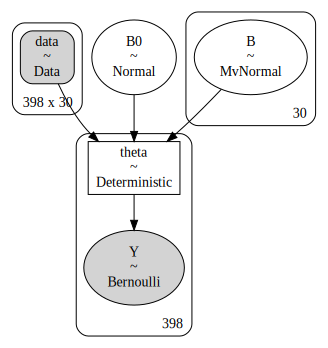

In [ ]:
pm.model_to_graphviz(cancer_model)

In [ ]:
# summary table
with cancer_model:
  main_idata = az.from_pymc3(trace_main)

az.summary(main_idata, var_names=['B0', 'B'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
B0,-0.32,0.44,-1.14,0.52,0.0,0.0,55219.28,54761.82,1.0
B[0],0.46,0.90,-1.27,2.13,0.0,0.0,67671.97,54587.84,1.0
B[1],0.45,0.57,-0.65,1.51,0.0,0.0,45946.65,49357.71,1.0
B[2],0.42,0.90,-1.28,2.10,0.0,0.0,68038.43,55792.49,1.0
B[3],0.54,0.92,-1.18,2.26,0.0,0.0,63307.65,52842.41,1.0
B[4],0.29,0.67,-0.98,1.54,0.0,0.0,60639.92,50915.46,1.0
B[5],-0.65,0.81,-2.19,0.88,0.0,0.0,60464.40,54636.32,1.0
B[6],0.86,0.83,-0.70,2.43,0.0,0.0,60848.91,51450.08,1.0
B[7],1.24,0.86,-0.39,2.85,0.0,0.0,66050.96,55414.62,1.0
B[8],-0.29,0.54,-1.30,0.73,0.0,0.0,63286.89,56456.62,1.0


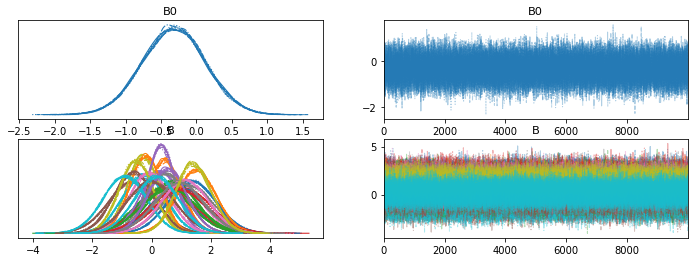

In [ ]:
# trace plots
with cancer_model:
  az.plot_trace(trace_main, var_names=['B0','B'])

Trace plots reveal that all beta coefficients converge to their respective mean values

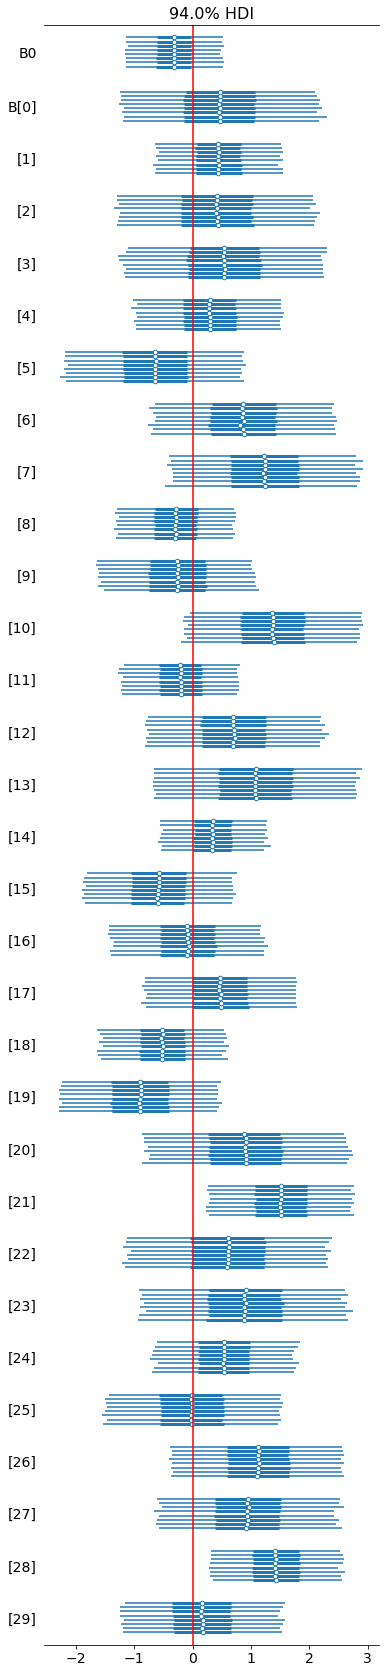

In [ ]:
# forest plots 
with cancer_model:
  pm.plot_forest(trace_main, var_names=['B0','B'])
  plt.axvline(color='r', linestyle='-')

In [ ]:
pd.DataFrame(all_predictors)

,0
0,radius_mean
1,texture_mean
2,perimeter_mean
3,area_mean
4,smoothness_mean
5,compactness_mean
6,concavity_mean
7,concave points_mean
8,symmetry_mean
9,fractal_dimension_mean


Based on the forest plot, 'radius_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'concavity_se', 'compactness_worst', 'fractal_dimension_worst' are not significant at p < 0.05, which we will remove to see if the performance of the model would improve after removal of these predictors.

## **Model 2**

Created by removing unuseful predictors based on the credible intervals overlapping 0 in the full model above.

In [ ]:
# Model 2

X_simple = X.drop(['radius_mean','perimeter_mean','area_mean','smoothness_mean',
                   'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'concavity_se', 
                   'compactness_worst', 'fractal_dimension_worst'], axis=1)

k_simple = X_simple.shape[1]

pd.DataFrame(X_simple)

,texture_mean,compactness_mean,concavity_mean,concave points_mean,radius_se,perimeter_se,area_se,smoothness_se,compactness_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,concavity_worst,concave points_worst,symmetry_worst
149,-0.321053,-0.769070,-0.753164,-0.919018,-0.560049,-0.640104,-0.415108,-1.401050,-0.534200,-0.968090,-0.878097,-0.688003,-0.192419,-0.523905,-0.299980,-0.271919,-1.545592,-0.555498,-0.828574,-0.891002
124,-0.674768,-0.589220,-0.098925,-0.539588,-0.870802,-0.813365,-0.564940,-0.374008,0.403626,-0.229711,-1.024602,0.106325,-0.416068,-0.476680,-0.454866,-0.436812,-1.309316,0.281190,-0.378019,-1.379572
421,-1.235591,1.502076,0.705598,0.363201,0.508999,0.954885,0.200500,0.978380,1.506886,0.649465,0.724982,0.623773,0.039513,-1.194821,0.203699,-0.125485,-0.051226,0.238492,-0.057956,-0.119321
195,-0.688730,-0.960480,-0.628619,-0.648697,-0.761442,-0.679706,-0.540958,-0.581017,-0.536994,-0.547642,-0.243646,-0.621431,-0.494759,-0.598813,-0.490013,-0.492186,-0.993698,-0.459548,-0.491153,0.199382
545,0.916946,-0.698760,-0.741488,-0.631673,-0.213564,-0.396054,-0.200151,-0.391009,-0.250840,-0.443179,0.039678,-0.458404,-0.190348,0.555750,-0.288363,-0.265064,-0.472051,-0.802570,-0.652707,-0.418610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-1.082004,0.924055,-0.034392,-0.521016,0.436815,0.149470,-0.327761,3.389811,3.811771,0.951175,0.589374,6.859624,-1.353531,-1.629614,-1.331463,-1.048038,-0.511503,-0.617866,-1.016318,-1.046309
106,-0.223317,-0.050051,-0.227236,-0.362899,-0.357933,-0.351996,-0.433809,0.499694,-0.132913,0.354244,-0.592352,0.017058,-0.648001,0.583433,-0.647878,-0.630885,1.597003,0.072498,0.109537,-0.153294
270,-0.574704,-1.470464,-1.023849,-1.100607,-0.992432,-1.001031,-0.650526,-1.183041,-1.216611,-1.328195,-0.627465,-0.913062,-0.281464,-0.818652,-0.381891,-0.344521,-2.047074,-1.120358,-1.237560,-0.716282
435,0.076875,0.169787,0.298817,0.405245,-0.665437,-0.625748,-0.472752,-0.575683,-0.422980,-0.361588,-1.006441,-0.358924,0.159621,0.834212,0.197742,-0.019835,1.268234,0.646282,1.036837,0.450138


In [ ]:
with pm.Model() as cancer_simple_model:
  
  data2 = pm.Data("data2", X_simple)

  beta0 = pm.Normal('beta0', mu=0, sd=1)
  beta = pm.MvNormal('beta', mu=np.zeros(k_simple), cov=np.eye(k_simple), shape=k_simple)

  mu = beta0 + pm.math.dot(data2, beta)
  theta = pm.Deterministic('theta', pm.invlogit(mu))

  Y = pm.Bernoulli('Y', p=theta, observed=y)

  trace_simple = pm.sample(1000, cores = 4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta, beta0]


Sampling 8 chains for 1_000 tune and 10_000 draw iterations (8_000 + 80_000 draws total) took 443 seconds.


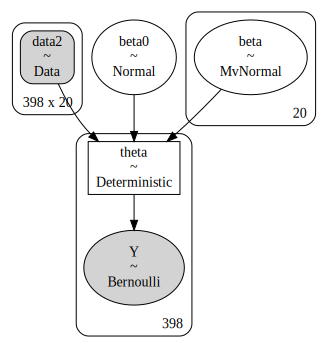

In [ ]:
pm.model_to_graphviz(cancer_simple_model)

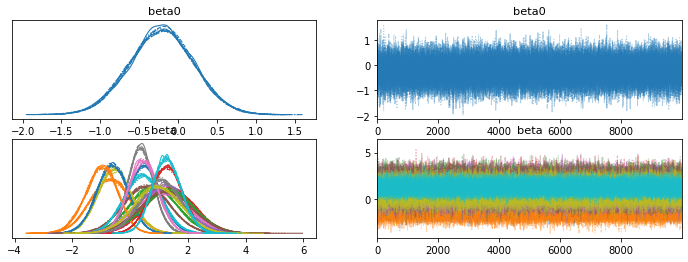

In [ ]:
# trace plots
with cancer_simple_model:
  az.plot_trace(trace_simple, var_names=['beta0','beta'])

In [ ]:
with cancer_simple_model:
  simple_idata = az.from_pymc3(trace_simple)
az.summary(simple_idata, var_names=['beta0','beta'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.22,0.41,-0.98,0.56,0.0,0.0,85419.29,61070.44,1.0
beta[0],0.50,0.55,-0.54,1.54,0.0,0.0,75623.03,58562.06,1.0
beta[1],-0.68,0.69,-1.99,0.59,0.0,0.0,93793.10,60644.11,1.0
beta[2],0.81,0.80,-0.66,2.33,0.0,0.0,96198.30,60713.75,1.0
beta[3],1.39,0.83,-0.16,2.95,0.0,0.0,98389.82,59475.89,1.0
beta[4],1.25,0.78,-0.21,2.74,0.0,0.0,94698.78,59411.56,1.0
beta[5],0.57,0.79,-0.92,2.04,0.0,0.0,93292.23,58645.50,1.0
beta[6],1.10,0.92,-0.64,2.81,0.0,0.0,105728.96,58053.72,1.0
beta[7],0.39,0.44,-0.44,1.23,0.0,0.0,66570.50,60434.75,1.0
beta[8],-0.53,0.58,-1.64,0.57,0.0,0.0,80340.49,61649.92,1.0


<Figure size 432x1008 with 0 Axes>

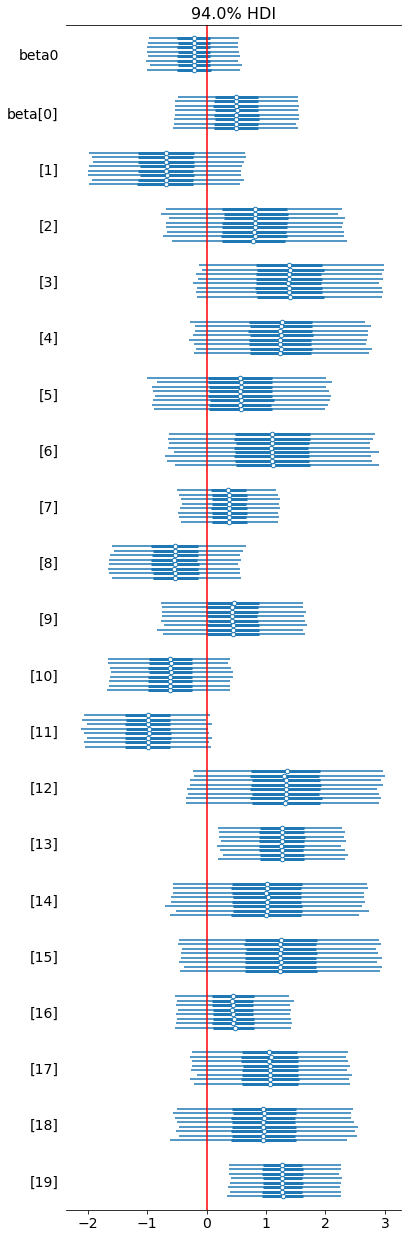

In [ ]:
# forest plots 
plt.figure(figsize=(6,14))
with cancer_simple_model:
  az.plot_forest(trace_simple, var_names=['beta0','beta'])
  plt.axvline(color='r', linestyle='-')

In [ ]:
pd.DataFrame(X_simple.columns)

,0
0,texture_mean
1,compactness_mean
2,concavity_mean
3,concave points_mean
4,radius_se
5,perimeter_se
6,area_se
7,smoothness_se
8,compactness_se
9,concave points_se


### **Model 3**: selecting and using two best performing predictors

In [ ]:
X3 = X[['texture_worst','symmetry_worst']]

k3 = X3.shape[1]

pd.DataFrame(X3)

,texture_worst,symmetry_worst
149,-0.523905,-0.891002
124,-0.476680,-1.379572
421,-1.194821,-0.119321
195,-0.598813,0.199382
545,0.555750,-0.418610
...,...,...
71,-1.629614,-1.046309
106,0.583433,-0.153294
270,-0.818652,-0.716282
435,0.834212,0.450138


In [ ]:
with pm.Model() as model3:

  data3 = pm.Data('data3', X3)

  beta0 = pm.Normal('beta0', mu=0, sd=1)
  beta = pm.MvNormal('beta', mu=np.zeros(k3), cov=np.eye(k3), shape=k3)

  mu = beta0 + pm.math.dot(data3, beta)
  theta = pm.Deterministic('theta', pm.invlogit(mu))

  Y = pm.Bernoulli('Y', p=theta, observed=y)

  trace3 = pm.sample(1000,cores=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta, beta0]


Sampling 8 chains for 1_000 tune and 10_000 draw iterations (8_000 + 80_000 draws total) took 138 seconds.


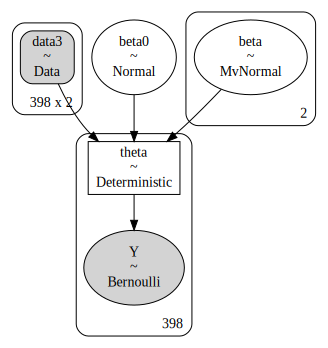

In [ ]:
pm.model_to_graphviz(model3)

In [ ]:
with model3:
  model3_idata = az.from_pymc3(trace3)
az.summary(model3_idata, var_names=['beta0','beta'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.59,0.13,-0.83,-0.34,0.0,0.0,99722.06,60420.78,1.0
beta[0],1.06,0.15,0.79,1.35,0.0,0.0,99419.26,57270.26,1.0
beta[1],1.17,0.18,0.83,1.52,0.0,0.0,101485.18,57599.82,1.0


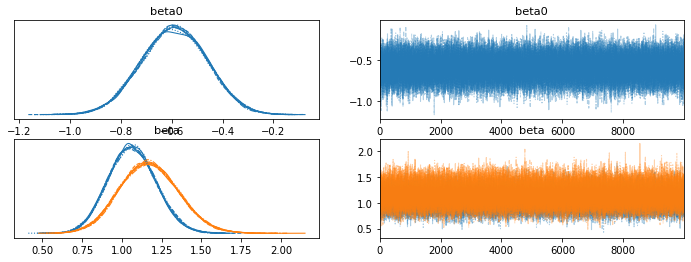

In [ ]:
# trace plots
with model3:
  az.plot_trace(trace3, var_names=['beta0','beta'])

<Figure size 432x1008 with 0 Axes>

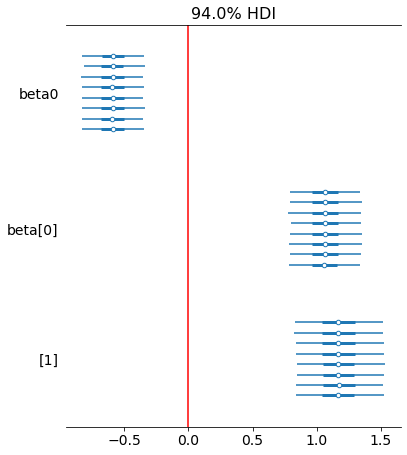

In [ ]:
# forest plots 
plt.figure(figsize=(6,14))
with model3:
  az.plot_forest(trace3, var_names=['beta0','beta'])
  plt.axvline(color='r', linestyle='-')

### Calculate the WAIC for each model

In [ ]:
cmp_cancer = az.compare({'main_model':trace_main, 'model_2':trace_simple, 'model_3':trace3}, 
                        ic='WAIC', scale='deviance')
cmp_cancer

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:1460: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future releas

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_2,0,61.162347,6.222374,0.000000,1.0,13.218186,0.000000,True,deviance
main_model,1,64.983385,8.135161,3.821038,0.0,15.433839,2.799450,True,deviance
model_3,2,381.437480,3.203817,320.275133,0.0,22.170085,22.297855,False,deviance


In [ ]:
# Use WAIC to produce a Bayesian model average result. 

pred_main = pm.sample_posterior_predictive_w(traces=[trace_main], samples=10000,
                                             models=[cancer_model])
pred_simple = pm.sample_posterior_predictive_w(traces=[trace_simple], samples=10000,
                                               models=[cancer_simple_model])
pred_3 = pm.sample_posterior_predictive_w(traces=[trace3], samples=10000,
                                             models=[model3])
pred_bma = pm.sample_posterior_predictive_w(traces=[trace_main, trace_simple, trace3],
                                            samples=10000, models=[cancer_model, cancer_simple_model,
                                                                   model3],
                                            weights=cmp_cancer['weight'])

**Kernel density plots of sample posterior predictions for each model and the BMA model**

<Figure size 1440x1080 with 0 Axes>

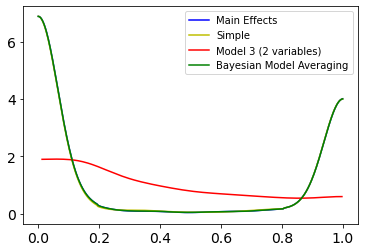

In [ ]:
models = [pred_main, pred_simple, pred_3, pred_bma]
colors = ['b', 'y', 'r', 'g']

# Show the kernel density plots for the sample posterior predictions of each of the models and the Bayesian model average.

plt.figure(figsize=(20,15))
fig, ax=plt.subplots()

labels = ['Main Effects', 'Simple', 'Model 3 (2 variables)', 'Bayesian Model Averaging']

for i, preds in enumerate(models):
  az.plot_kde(preds['Y'].mean(0), plot_kwargs={'color':colors[i]},label=labels[i], ax=ax)

plt.show()

**Predicting with Bayesian Logistic Regression**

In [ ]:
with cancer_model:
    pm.set_data({"data": test_X})
    post_pred = pm.sample_posterior_predictive(trace_main, samples=1000)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [ ]:
p_test_pred = post_pred["Y"].mean(axis=0)
y_test_pred = (p_test_pred >= 0.5).astype("int")

**Full Model: Prediction Results** 

In [ ]:
from sklearn.metrics import accuracy_score

print(f"accuracy = {accuracy_score(y_true=test_y, y_pred=y_test_pred): 0.3f}")

accuracy =  0.994


In [ ]:
sklearn.metrics.confusion_matrix(test_y,y_test_pred )

array([[108,   0],
       [  1,  62]])

In [ ]:
test_X2 = test_X.drop(['radius_mean','compactness_mean','symmetry_mean','fractal_dimension_mean',
                   'texture_se', 'compactness_se', 'concavity_se', 'symmetry_se', 
                   'fractal_dimension_se', 'compactness_worst'], axis=1)

In [ ]:
with cancer_simple_model:
    pm.set_data({"data2": test_X2})
    post_pred = pm.sample_posterior_predictive(trace_simple, samples=1000)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [ ]:
p_test_pred = post_pred["Y"].mean(axis=0)
y_test_pred = (p_test_pred >= 0.5).astype("int")

**Model 2: Prediction Results**

In [ ]:
from sklearn.metrics import accuracy_score

print(f"accuracy = {accuracy_score(y_true=test_y, y_pred=y_test_pred): 0.3f}")

accuracy =  0.901


In [ ]:
sklearn.metrics.confusion_matrix(test_y,y_test_pred)

array([[96, 12],
       [ 5, 58]])

In [ ]:
test_X3 = test_X[['texture_worst','symmetry_worst']]

In [ ]:
with model3:
    pm.set_data({"data3": test_X3})
    post_pred = pm.sample_posterior_predictive(trace3, samples=1000)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [ ]:
p_test_pred = post_pred["Y"].mean(axis=0)
y_test_pred = (p_test_pred >= 0.5).astype("int")

**Model 3: Prediction Results**

In [ ]:
from sklearn.metrics import accuracy_score

print(f"accuracy = {accuracy_score(y_true=test_y, y_pred=y_test_pred): 0.3f}")

accuracy =  0.725


In [ ]:
sklearn.metrics.confusion_matrix(test_y,y_test_pred)

array([[104,   4],
       [ 13,  50]])

Classic Logistic Regression

In [ ]:
test_y.shape

(171,)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X, y)

LogisticRegression()

In [ ]:
y_pred = logreg.predict(test_X)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_X, test_y)))

Accuracy of logistic regression classifier on test set: 0.98


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_y, y_pred)
print(confusion_matrix)


[[106   2]
 [  1  62]]
